WORK ON NATIVE GRIDS!!! This will allow access to more models
No - how do you define teh S. Ocean on a crazy grid!

In [246]:
import iris
import matplotlib.pyplot as plt
import iris.quickplot as qplt
import glob
import os
import numpy as np
import iris.coord_categorisation
import pandas as pd
import matplotlib
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.gridspec as gridspec
import pickle
import iris.coord_categorisation

In [247]:
yearsec=60.0*60.0*24.0*365
kg2mol_C = 1000.0/12.0

In [248]:
def area_avg_with_areacello(cube,cube_areacello):
    cube_areacello_tmp = cube_areacello.copy()
    no_time_steps = len(cube.coord('time').points)
    tmp = cube.copy()
    if no_time_steps > 1:
        tmp.data = cube.data * np.tile(cube_areacello_tmp.data,[no_time_steps,1,1])
    else:
        tmp.data = cube.data * cube_areacello_tmp.data
    cube_areacello_masked = cube_areacello_tmp.copy()
    cube_areacello_masked.data = np.ma.masked_array(cube_areacello_masked.data)
    if no_time_steps > 1:
        cube_areacello_masked.data.mask = cube[0].data.mask
    else:
        cube_areacello_masked.data.mask = cube.data.mask
    tmp /= np.ma.mean(cube_areacello_masked.data)
    return tmp.collapsed(['latitude','longitude'],iris.analysis.MEAN)


def area_sum_with_areacello(cube,cube_areacello):
    cube_areacello_tmp = cube_areacello.copy()
    no_time_steps = len(cube.coord('time').points)
    tmp = cube.copy()
    if no_time_steps > 1:
        tmp.data = cube.data * np.tile(cube_areacello_tmp.data,[no_time_steps,1,1])
    else:
        tmp.data = cube.data * cube_areacello_tmp.data
    cube_areacello_masked = cube_areacello_tmp.copy()
    cube_areacello_masked.data = np.ma.masked_array(cube_areacello_masked.data)
    if no_time_steps > 1:
        cube_areacello_masked.data.mask = cube[0].data.mask
    else:
        cube_areacello_masked.data.mask = cube.data.mask
    return tmp.collapsed(['latitude','longitude'],iris.analysis.SUM)


def model_names(directory):
	files = glob.glob(directory+'/*.nc')
	models_tmp = []
	for file in files:
		statinfo = os.stat(file)
		if statinfo.st_size >= 1:
			models_tmp.append(file.split('/')[-1].split('_')[0])
			models = np.unique(models_tmp)
	return models

def model_names_var(directory,var,grid):
	files = glob.glob(directory+'/*'+var+'*'+grid+'*.nc')
	models_tmp = []
	for file in files:
		statinfo = os.stat(file)
		if statinfo.st_size >= 1:
			models_tmp.append(file.split('/')[-1].split('_')[0])
			models = np.unique(models_tmp)
	return models

def model_names_var_cmip5(directory,var):
	files = glob.glob(directory+'/*'+var+'*.nc')
	models_tmp = []
	for file in files:
		statinfo = os.stat(file)
		if statinfo.st_size >= 1:
			models_tmp.append(file.split('/')[-1].split('_')[0])
			models = np.unique(models_tmp)
	return models

def mask_where_zero(cube):
    cube.data = np.ma.masked_array(cube.data)
    cube.data.fill_value= 9.99e9
    cube.data[np.where(cube.data == 0.0)] = 9.99e9
    cube.data = np.ma.masked_where(cube.data == 9.99e9,cube.data)
    return cube

def extract_region(cube,lon_west,lon_east,lat_south,lat_north):
    cube_region_tmp = cube.intersection(longitude=(lon_west, lon_east))
    cube_region = cube_region_tmp.intersection(latitude=(lat_south, lat_north))
    return cube_region


def area_sum(cube):
#     first_dim = cube.coord(dimensions=1).long_name #latitude
#     second_dim = cube.coord(dimensions=2).long_name #longitude
    try:
        cube.coord('latitude').guess_bounds()
    except:
        pass
    try:
        cube.coord('longitude').guess_bounds()
    except:
        pass
    grid_areas = iris.analysis.cartography.area_weights(cube)
    area_avged_cube = cube.collapsed(['longitude', 'latitude'], iris.analysis.SUM, weights=grid_areas)
    return area_avged_cube

def area_avg(cube):
#     first_dim = cube.coord(dimensions=1).long_name #latitude
#     second_dim = cube.coord(dimensions=2).long_name #longitude
    try:
        cube.coord('latitude').guess_bounds()
    except:
        pass
    try:
        cube.coord('longitude').guess_bounds()
    except:
        pass
    grid_areas = iris.analysis.cartography.area_weights(cube)
    area_avged_cube = cube.collapsed(['longitude', 'latitude'], iris.analysis.MEAN, weights=grid_areas)
    return area_avged_cube

def area_sum2(cube,lon_west,lon_east,lat_south,lat_north):
    cube = extract_region(cube,lon_west,lon_east,lat_south,lat_north)
#     first_dim = cube.coord(dimensions=1).long_name #latitude
#     second_dim = cube.coord(dimensions=2).long_name #longitude
    try:
        cube.coord('latitude').guess_bounds()
    except:
        pass
    try:
        cube.coord('longitude').guess_bounds()
    except:
        pass
    grid_areas = iris.analysis.cartography.area_weights(cube)
    area_avged_cube = cube.collapsed(['longitude', 'latitude'], iris.analysis.SUM, weights=grid_areas)
    return area_avged_cube

def area_avg2(cube,lon_west,lon_east,lat_south,lat_north):
    cube = extract_region(cube,lon_west,lon_east,lat_south,lat_north)
#     first_dim = cube.coord(dimensions=1).long_name #latitude
#     second_dim = cube.coord(dimensions=2).long_name #longitude
    try:
        cube.coord('latitude').guess_bounds()
    except:
        pass
    try:
        cube.coord('longitude').guess_bounds()
    except:
        pass
    grid_areas = iris.analysis.cartography.area_weights(cube)
    area_avged_cube = cube.collapsed(['longitude', 'latitude'], iris.analysis.MEAN, weights=grid_areas)
    return area_avged_cube

def avg_years(cube,start_yr,end_yr):
    try:
        iris.coord_categorisation.add_year(cube, 'time', name='year')
    except:
        pass
    loc = np.where((cube.coord('year').points >= start_yr) & (cube.coord('year').points <= end_yr))
    if len(loc[0]) > 0:
        return cube[loc].collapsed('time', iris.analysis.MEAN)
    else:
        cube=cube.collapsed('time', iris.analysis.MEAN)
        cube.data[:] = np.nan
        return cube

                   
def return_years(cube):
    try:
        iris.coord_categorisation.add_year(cube, 'time', name='year')
    except:
        pass
    return cube.coord('year').points


def year_mean(cube):
    try:
        iris.coord_categorisation.add_year(cube, 'time', name='year')
    except:
        pass
    return cube.aggregated_by('year', iris.analysis.MEAN)

def populate_dict(data_dict,directory,models,variable,run,test_value):
    lon_west,lon_east,lat_south,lat_north=-80.0,10,0.0,80.0
    for model in models:
        go_ahead = True
        print model
        exists = os.path.isfile(directory+model+'_'+variable+'_'+run+'_r1i1p1_regridded.nc')
        if exists:
            cube = iris.load_cube(directory+model+'_'+variable+'_'+run+'_r1i1p1_regridded.nc')
#             cube = cube.collapsed(['depth'],iris.analysis.MEAN)
            iris.coord_categorisation.add_year(cube, 'time', name='year')
            cube = cube.aggregated_by('year', iris.analysis.MEAN)
            test = cube.collapsed(['latitude','longitude','time'],iris.analysis.MEAN)
            if test_value:
                if test.data > 0.6e-9:
                    go_ahead=False
            if go_ahead:
                first_dim = cube.coord(dimensions=1).long_name #latitude
                if first_dim == 'latitude':
    #                 cube.coord(dimensions=1).rename('latitude')
    #                 cube.coord(dimensions=2).rename('longitude')
                    cube = extract_region(cube,lon_west,lon_east,lat_south,lat_north)
                    data_dict[run][variable][model] = {}
                    data_dict[run][variable][model]['timeseries'] = area_sum(cube)
                    data_dict[run][variable][model]['timeseries_avg'] = area_avg(cube)
                    data_dict[run][variable][model]['years'] = return_years(cube)
                    data_dict[run][variable][model]['first20'] = first_20_avg = avg_years(cube,2006,2026)
                    data_dict[run][variable][model]['last20'] = last_20_avg = avg_years(cube,2079,2099)
        else:
            print directory+model+'_'+variable+'_'+run+'_r1i1p1_regridded.nc does not exist'
    return data_dict


def populate_dict_region(data_dict_region,directory,models,variables,runs,test_value,region_bounds):
    regions = list(region_bounds)
    #     lon_west,lon_east,lat_south,lat_north = W,E,S,N
    for i,region in enumerate(regions):
        W,E,S,N = region_bounds[region]['W'],region_bounds[region]['E'],region_bounds[region]['S'],region_bounds[region]['N']
        for run in runs:
            for variable in variables:
                for model in models:
                    exists = os.path.isfile(directory+model+'_'+variable+'_'+run+'_r1i1p1_regridded.nc')
                    if exists:
                        cube = iris.load_cube(directory+model+'_'+variable+'_'+run+'_r1i1p1_regridded.nc')
                        iris.coord_categorisation.add_year(cube, 'time', name='year')
                        cube = cube.aggregated_by('year', iris.analysis.MEAN)
                        cube = extract_region(cube,W,E,S,N)
                        data_dict_region[region][run][variable][model] = {}
                        data_dict_region[region][run][variable][model]['timeseries'] = area_sum(cube)
                        data_dict_region[region][run][variable][model]['timeseries_avg'] = area_avg(cube)
                        data_dict_region[region][run][variable][model]['years'] = return_years(cube)
                        data_dict_region[region][run][variable][model]['first20'] = avg_years(cube,2006,2026)
                        data_dict_region[region][run][variable][model]['last20'] = avg_years(cube,2079,2099)
                    else:
                        print directory+model+'_'+variable+'_'+run+'_r1i1p1_regridded.nc does not exist'
    return data_dict_region


def populate_dict_region_profile(data_dict_region_profiles,directory,models,variables,runs,test_value,region_bounds):
    regions = list(region_bounds)
    #     lon_west,lon_east,lat_south,lat_north = W,E,S,N
    for i,region in enumerate(regions):
        W,E,S,N = region_bounds[region]['W'],region_bounds[region]['E'],region_bounds[region]['S'],region_bounds[region]['N']
        data_dict_region_profiles[region]={}
        for run in runs:
            data_dict_region_profiles[region][run]={}
            for variable in variables:
                data_dict_region_profiles[region][run][variable]={}
                for model in models:
                    data_dict_region_profiles[region][run][variable][model]={}
                    print run, variable, model
                    exists = os.path.isfile(directory+model+'_'+variable+'_'+run+'_r1i1p1_regridded.nc')
                    if exists:
                        print 'ok'
                        cube = iris.load_cube(directory+model+'_'+variable+'_'+run+'_r1i1p1_regridded.nc')
                        iris.coord_categorisation.add_year(cube, 'time', name='year')
                        cube = cube.aggregated_by('year', iris.analysis.MEAN)
                        tmp_cube = area_avg(extract_region(cube,W,E,S,N))
                        first20_profile = avg_years(tmp_cube,2006,2026)
                        last20_profile = avg_years(tmp_cube,2079,2099)
                        depth = first20_profile.coord('depth').points
                        data_dict_region_profiles[region][run][variable][model]['first20_profile'] = first20_profile.data
                        data_dict_region_profiles[region][run][variable][model]['last20_profile'] = last20_profile.data
                        data_dict_region_profiles[region][run][variable][model]['depths'] = depth
                    else:
                        print directory+model+'_'+variable+'_'+run+'_r1i1p1_regridded.nc does not exist'
    return data_dict_region_profiles


def mask_cube_if_no_mask(cube):
    if (not ma.is_masked(cube.data)) | (cube_fgco2[0].data.mask.shape == ()):
        test = np.where(cube.data == np.nan)
        if test > 1e3:
            tmp = cube.data.copy()
            tmp = np.ma.masked_array(tmp)
            tmp2 = np.ma.masked_where(tmp.data == np.nan,tmp)
            cube.data = tmp2
        test = np.where(cube.data == 0.0)
        if test > 1e3:
            tmp = cube.data.copy()
            tmp = np.ma.masked_array(tmp)
            tmp2 = ma.masked_where(tmp.data == 0.0,tmp)
            cube.data = tmp2
    return cube

def collapse_depth(cube):
    if len(np.shape(cube)) == 4:
        try:
            cube = cube.collapsed('depth',iris.analysis.MEAN)
        except:
            try:
                cube = cube.collapsed('lev',iris.analysis.MEAN)
            except:
                try:
                    name = cube.coord(dimensions=1).long_name
                    cube = cube.collapsed(name,iris.analysis.MEAN)
                except:
                    name = cube.coord(dimensions=1).standard_name
                    cube = cube.collapsed(name,iris.analysis.MEAN)
    return cube

def mask_where_seaice(cube,max_seaice):
    sic_mask = np.tile(max_seaice.data,[np.shape(cube)[0],1,1])
    cube_data = cube.data.copy()
    cube_data = np.ma.masked_where(sic_mask > 0.0, cube_data)
#     print cube_data.mask.dtype
#     cube_data.mask[np.where(sic_mask > 0)] = True
    cube.data = cube_data
    return cube


# def mask_where_seaice(cube,max_seaice):
#     sic_mask = np.tile(max_seaice.data,[np.shape(cube)[0],1,1])
#     cube_data = cube.data.data.copy()
#     cube_data = np.array(cube_data)
#     cube_data = np.ma.masked_array(cube_data)
# #     cube_data.mask[:] = True
#     cube_data.mask[np.where(sic_mask > 0.0)] = True
#     cube.data = cube_data
#     return cube

In [249]:
'''
Carbon chemistry calulations
Input should be:
Temperature in K
S in PSU (I think)
DIC and ALK in MOL? values about 2.0
'''

'''
NOTE - this is currently designed to work with a single time-interval (i.e. cube without a time dimension)
'''

import numpy as np
import numpy.ma as ma
import scipy.stats
import keyword
import warnings
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore", category=RuntimeWarning)

print'  ops= 0 ;  output is iteration count'
print'       1 ;            pCO2'
print'       2 ;            pH'
print'       3 ;            [H2CO3]'
print'       4 ;            [HCO3]'
print'       5 ;            [CO3]'
print'       6 ;            satn [co3] : calcite'
print'       7 ;            saturation state: calcite'
print'       8 ;            satn [CO3] : aragonite'
print'       9 ;            saturation state: aragonite'
print'       10;            Ravelle factor (DIC) calculated from Egleston et al. 2010'
print'       11;            Alkalinity buffer factor calculated from Egleston et al. 2010'

print 'inputs: op_swtch,mdi,T,S,TCO2,TALK'

#Supply these as .data (arrays)
#salinity needs to be converted into psu *1000+35
#TCO2 and TALK must be in mol/kg /(1026.*1000.)
#the ones below here are not needed


def pressure_fun(a,b,c,d,e,T):
    del_vol = np.ones(T.shape, dtype='f')
    del_com = np.ones(T.shape, dtype='f') 
    pf = np.ones(T.shape, dtype='f')
    del_vol = a + b *T + c * np.power(T,2.0)
    del_com = 1.0e-3*( d + e*T )
    pf = np.exp( ( 0.5*del_com*Pr   - del_vol )*Pr / ( 83.131*TK ) )
    return pf

def carbiter(T, TCO2, TALK, TB, msk, tol, mxiter, K1, K2, KB, KW):
    aH = np.empty_like(T, dtype='f')
    aH.fill(1.0e-8)
    count = np.zeros_like(T)
    tol_swtch = np.zeros_like(T)
#MB -
#    AB = np.ones(T.shape)
#    AC = np.ones(T.shape)
#    AW = np.ones(T.shape)
    
    #MB+
    TBKB = TB * KB
    K2_K1x4 = 4.0 * K2 / K1
    K2_2 = 0.5 * K1
    #
    
    iter = 0
    test = 2.0
    while test > 0.5 and iter < mxiter:
        # Compute alkalinity guesses for Boron, Silicon, Phosphorus and Water
        #MB- AB = TB * KB / (aH + KB)
        #AB = TBKB / (aH + KB)
        AB = np.divide(TBKB,(aH + KB))
        #  ASi = TSi*KSi/( aH $
        #    + KSi )
        #  AP = TP*( 1.0/( 1.0 + KP2/aH $
        #    + KP2*KP3/(aH^2.0) ) + 2.0/( 1.0 $
        #    + aH/KP2 + KP3/aH ) $
        #    + 3.0/( 1.0 + aH/KP3 $
        #    + (aH^2.0)/(KP2*KP3) ) )
        AW = (KW / aH) - aH
        # using the guessed alkalinities and total alkalinity, calculate the
        # alkalinity due to carbon
        #  AC = TALK - ( AB + ASi $
        #    + AP + AW )
        AC = TALK - (AB + AW)
        # and recalculate aH with the new As
        #MB+
        TCO2_AC = TCO2 - AC
        #
        old_aH = np.copy(aH)
        #MB- aH = (0.5 * K1 / AC) * ((TCO2 - AC) + np.sqrt((TCO2 - AC) * (TCO2 - AC) + 4.0 * (AC * K2 / K1) * (2.0 * TCO2 - AC)))
        temp = TCO2_AC*TCO2_AC + (AC * K2_K1x4) * (2.0 * TCO2 - AC)
        aH = (K2_2 / AC) * (TCO2_AC + np.sqrt(temp))
        tol_swtch = abs((aH - old_aH) / old_aH) > tol
        count = count + tol_swtch
        test = np.sum(tol_swtch)
        iter += 1
        
    #aH[~msk] = 1.0
    #count[~msk] = 0
    return AC, AW, AB, aH, count


def carbchem_revelle(op_swtch,mdi,T_cube,S_cube,TCO2_cube,TALK_cube,Pr=0.0,TB=0.0,Ni=100.0,Tl=1.0e-5):
# This function calculates the inorganic carbon chemistry balance
# according to the method of Peng et al 1987
# The parameters are set in the first few lines

#salinity needs to be converted into psu
#TCO2 and TALK must be in mol/kg
#the ones below here are not needed

# This procedure calculates the inorganic carbon chemistry balance
# according to the method of Peng et al 1987
# The parameters are set in the first few lines
#
#  ops= 0 ;  output is iteration count
#       1 ;            pCO2
#       2 ;            pH
#       3 ;            [H2CO3]
#       4 ;            [HCO3]
#       5 ;            [CO3]
#       6 ;            satn [co3] : calcite
#       7 ;            saturation state: calcite
#       8 ;            satn [CO3] : aragonite
#       9 ;            saturation state: aragonite
#	10;            Ravelle factor (DIC) calculated from Egleston et al. 2010
#	11;            Alkalinity buffer factor calculated from Egleston et al. 2010

    #make sure grids are same size
    #make sure rthey years are the same
    #extarct the data from the cubes
    
# from iris import *
# from iris.analysis import *
# import iris.analysis
# from numpy import *
# from matplotlib.pyplot import *
# from scipy.stats.mstats import *
# import iris.plot as iplt
# import seawater
# import numpy
# import iris.quickplot as quickplot
# import iris.analysis.stats as istats
# temp = iris.load_cube('/home/ph290/tmp/hadgem2es_potential_temperature_historical_regridded.nc').extract(Constraint(depth = 0))
# sal = iris.load_cube('/home/ph290/tmp/hadgem2es_salinity_historical_regridded.nc').extract(Constraint(depth = 0))
# carb = iris.load_cube('/home/ph290/tmp/hadgem2es_dissolved_inorganic_carbon_historical_regridded.nc').extract(Constraint(depth = 0))
# alk = iris.load_cube('/home/ph290/tmp/hadgem2es_total_alkalinity_historical_regridded.nc').extract(Constraint(depth = 0))
# import carbchem
# co2 = carbchem.carbchem(1,temp.data.fill_value,temp,sal,carb,alk)
# T_cube = temp
# S_cube = sal
# TCO2_cube = carb
# TALK_cube = alk  
# mdi = temp.data.fill_value
	
    t_lat = np.size(T_cube.coord('latitude').points)    
    s_lat = np.size(S_cube.coord('latitude').points)
    c_lat = np.size(TCO2_cube.coord('latitude').points)
    a_lat = np.size(TALK_cube.coord('latitude').points)
    lat_test = t_lat == s_lat == c_lat == a_lat

    t_lon = np.size(T_cube.coord('longitude').points) 
    s_lon = np.size(S_cube.coord('longitude').points)
    c_lon = np.size(TCO2_cube.coord('longitude').points)
    a_lon = np.size(TALK_cube.coord('longitude').points)
    lon_test = t_lon == s_lon == c_lon == a_lon

    if lat_test and lon_test:
        output_cube = T_cube.copy()
        T_cube = T_cube
        T = T_cube.data.copy()
        S = S_cube.data.copy()
        TCO2_cube = TCO2_cube/1026.0
        # 		TCO2 = np.roll(ma.swapaxes(TCO2_cube.data.copy(),0,1),180)
        TCO2=TCO2_cube.data.copy()
        #NOTE - this is only required here 'cos glodap and WOA are differently ordered - not necessary for other stuff
        TALK_cube = TALK_cube/1026.0
        # 		TALK = np.roll(ma.swapaxes(TALK_cube.data.copy(),0,1),180)
        TALK = TALK_cube.data.copy()

#         print np.mean(T)
#         print np.mean(S)
#         print np.mean(TCO2)
#         print np.mean(TALK)
#         print np.shape(T)
#         print np.shape(S)
#         print np.shape(TCO2)
#         print np.shape(TALK)
        msk1=ma.masked_greater_equal(T,mdi-1.0,copy=True)
        msk2=ma.masked_greater_equal(S,mdi-1.0,copy=True)
        msk3=ma.masked_greater_equal(TCO2,mdi-1.0,copy=True)
        msk4=ma.masked_greater_equal(TALK,mdi-1.0,copy=True)

        msk=msk1.mask | msk2.mask | msk3.mask | msk4.mask

        T[msk]=np.nan
        S[msk]=np.nan
        TALK[msk]=np.nan
        TCO2[msk]=np.nan
        # 		plt.contourf(T)
        # 		plt.show()
        # 		plt.contourf(TCO2)
        # 		plt.show()

        # T = np.array([13.74232016,25.0])
        # S = np.array([33.74096661,35.0])
        # TCO2 = np.array([0.0019863,2.0e-3])
        # TALK = np.array([0.00226763,2.2e-3])
        # msk = ma.masked_greater_equal(T,mdi-1.0,copy=True)

        #create land-sea mask used by sea_msk.mask
        salmin = 1.0
        S2=np.copy(S)
        S2[np.abs(S) < salmin]=salmin

        tol = Tl
        mxiter = Ni

        op_fld = np.empty(T.shape)
        op_fld.fill(np.NAN)

        #    TB = np.ones(T.shape)
        #    TB = 4.106e-4*S2/35.0
        TB = np.empty_like(T)
        TB = np.multiply(S2,4.106e-4/35.0, TB)
        # this boron is from Peng

        #convert to Kelvin
        TK=np.copy(T[:])
        TK += +273.15

        alpha_s = np.ones(T.shape)
        alpha_s = np.exp( ( -60.2409 + 9345.17/TK  + 23.3585*np.log(TK/100.0) )  + ( 0.023517 - 0.023656*(TK/100.0) + 0.0047036*np.power((TK/100.0),2.0) )*S )

        K1 = np.ones(T.shape)
        K1 = np.exp( ( -2307.1266/TK + 2.83655  - 1.5529413*np.log(TK) ) - ( 4.0484/TK + 0.20760841 )*np.sqrt(S) + 0.08468345*S - 0.00654208*np.power(S,1.5) + np.log( 1.0 - 0.001005*S ) )

        a = np.array([-25.50,-15.82,-29.48,-25.60,-48.76,-46.0])
        b = np.array([0.1271,0.0219,0.2324,0.5304,0.5304])
        c = np.array([0.0,0.0,0.0026080,0.0036246,0.0,0.0])
        d = np.array([-3.08,1.13,(-2.84e-3)/(1.0e-3),-5.13,-11.76,-11.76])
        e = np.array([0.0877,0.1475,0.0,0.0794,0.3692,0.3692])

        if keyword.iskeyword(Pr):
            instance = 0
            pf = pressure_fun(a[instance],b[instance],c[instance],d[instance],e[instance],T)
            K1 = K1*pf

        K2 = np.ones(T.shape)
        K2 = np.exp( ( -3351.6106/TK - 9.226508 - 0.2005743*np.log(TK) ) - ( 23.9722/TK + 0.106901773 )*np.power(S,0.5) + 0.1130822*S - 0.00846934*np.power(S,1.5) + np.log( 1.0 - 0.001005*S ) )

        if keyword.iskeyword(Pr):
            instance = 1
            pf = pressure_fun(a[instance],b[instance],c[instance],d[instance],e[instance],T)
            K2 = K2*pf

        KB = np.ones(T.shape)
        KB = np.exp( ( -8966.90 - 2890.53*np.power(S,0.5) - 77.942*S + 1.728*np.power(S,1.5)- 0.0996*np.power(S,2.0) )/TK + ( 148.0248 + 137.1942*np.power(S,0.5) + 1.62142*S ) - ( 24.4344 + 25.085*np.power(S,0.5) + 0.2474*S )*np.log(TK) + 0.053105*(np.power(S,0.5))*TK )

        if keyword.iskeyword(Pr):
            instance = 2
            pf = pressure_fun(a[instance],b[instance],c[instance],d[instance],e[instance],T)
            KB = KB*pf

        KW = np.ones(T.shape)
        KW = np.exp( ( -13847.26/TK + 148.96502 - 23.6521*np.log(TK) ) + ( 118.67/TK - 5.977 + 1.0495*np.log(TK) )*np.power(S,0.5) - 0.01615*S )

        if keyword.iskeyword(Pr):
            instance = 3
            pf = pressure_fun(a[instance],b[instance],c[instance],d[instance],e[instance],T)
            KW = KW*pf

        if ( op_swtch >= 6 or op_swtch <= 9 ):
            ca_conc = np.ones(T.shape)
            ca_conc = 0.01028*S2/35.0

        if ( op_swtch == 6 or op_swtch == 7 ):
            K_SP_C = np.ones(T.shape)
            K_SP_C = np.power(10.0,( ( -171.9065 - 0.077993*TK + 2839.319/TK + 71.595*np.log10(TK) ) + ( -0.77712 + 0.0028426*TK + 178.34/TK )*np.power(S,0.5) - 0.07711*S+ 0.0041249*np.power(S,1.5) ))
            if keyword.iskeyword(Pr):
                instance = 4
                pf = pressure_fun(a[instance],b[instance],c[instance],d[instance],e[instance],T)
                K_SP_C = K_SP_C*pf


        if ( op_swtch == 8 or op_swtch == 9 ):
            K_SP_A = np.ones(T.shape)
            K_SP_A = np.power(10,( ( -171.945 - 0.077993*TK + 2903.293/TK + 71.595*np.log10(TK) ) + ( -0.068393 + 0.0017276*TK + 88.135/TK )*np.power(S,0.5) - 0.10018*S + 0.0059415*np.power(S,1.5) ))
            if keyword.iskeyword(Pr):
                instance = 5
                pf = pressure_fun(a[instance],b[instance],c[instance],d[instance],e[instance],T)
                K_SP_A = K_SP_A*pf


        # Get first estimate for H+ concentration.

        AC, AW, AB, aH, count = carbiter(T, TCO2, TALK, TB, msk, tol, mxiter, K1, K2, KB, KW)

        # 		plt.contourf(aH)
        # 		plt.show()
        # 		plt.contourf(AC)
        # 		plt.show()
        # 		plt.contourf(AW)
        # 		plt.show()
        # 		plt.contourf(aH)
        # 		plt.show()

        # now we have aH we can calculate...
        denom = np.zeros(T.shape)
        H2CO3 = np.zeros(T.shape)
        HCO3 = np.zeros(T.shape)
        CO3 = np.zeros(T.shape)
        pH = np.zeros(T.shape)
        pCO2 = np.zeros(T.shape)
        if ( op_swtch == 6 or op_swtch == 7 ):
            sat_CO3_C = np.zeros(T.shape)
        if ( op_swtch == 7 ):
            sat_stat_C = np.zeros(T.shape)
        if ( op_swtch == 8 or op_swtch == 9 ):
            sat_CO3_A = np.zeros(T.shape)
        if ( op_swtch == 9 ):
            sat_stat_A = np.zeros(T.shape)

        denom = np.power(aH,2.0) + K1*aH + K1*K2
        H2CO3 = TCO2*np.power(aH,2.0)/denom
        HCO3 = TCO2*K1*aH/denom
        CO3 = TCO2*K1*K2/denom
        # 		plt.contourf(K1)
        # 		plt.show()
        # 		plt.contourf(aH) -no
        # 		plt.show()
        # 		plt.contourf(denom) -no
        # 		plt.show()

        pH = -np.log10(aH)
        pCO2 = H2CO3/alpha_s

        if ( op_swtch == 6 or op_swtch == 7 ):
            sat_CO3_C = K_SP_C/ca_conc
            if ( op_swtch == 7 ):
                sat_stat_C = CO3/sat_CO3_C

        if ( op_swtch == 8 or op_swtch == 9 ):
            sat_CO3_A = K_SP_A/ca_conc
            if ( op_swtch == 9 ):
                sat_stat_A = CO3/sat_CO3_A

        TALKc=+HCO3+2*(CO3)
        var1=HCO3
        DIC_buffer=HCO3
        ALK_buffer=HCO3

        var1=HCO3+4*(CO3)+((aH*AB)/(KB+aH))-AW

        DIC_buffer=TCO2-((TALKc*TALKc)/var1)

        ALK_buffer=((TALKc*TALKc)-TCO2*var1)/TALKc

        output_cube = output_cube*0.0+np.nan
        if ( op_swtch == 0 ):
            op_fld = np.zeros(T.shape)
            op_fld = count
        elif ( op_swtch == 1 ):
            print np.mean(pCO2)
            output_cube.data = pCO2*1.0e6
            output_cube.standard_name = 'surface_partial_pressure_of_carbon_dioxide_in_sea_water'
            output_cube.long_name = 'CO2 concentration'
            output_cube.units = 'uatm'
        elif ( op_swtch == 2 ):
            output_cube.data = pH
            output_cube.standard_name = 'sea_water_ph_reported_on_total_scale'
            output_cube.long_name = 'pH'
            output_cube.units = '1'
        elif ( op_swtch == 3 ):
            output_cube.data = H2CO3
        elif ( op_swtch == 4 ):
            output_cube.data = HCO3
        elif ( op_swtch == 5 ):
            output_cube.data = CO3
        elif ( op_swtch == 6 ):
            output_cube.data = sat_CO3_C
        elif ( op_swtch == 7 ):
            output_cube.data = sat_stat_C
        elif ( op_swtch == 8 ):
            output_cube.data = sat_CO3_A
        elif ( op_swtch == 9 ):
            output_cube.data = sat_stat_A
        elif ( op_swtch == 10 ):
            output_cube.data = TCO2/DIC_buffer
        elif ( op_swtch == 11 ):
            output_cube.data = ALK_buffer*1000.0

        return output_cube


'''
test-data
'''

# def main():
# mdi=-999.0
# sizing=(500,500)
# T = np.empty(sizing)
# S = np.empty(sizing)
# TCO2 = np.empty(sizing)
# TALK = np.empty(sizing)
# T.fill(10.0)
# S.fill(35.0)
# TCO2.fill(0.0020)
# TALK.fill(0.0022)
# T[0,0]=mdi
# S[2,3]=mdi
# S[0,0]=0.5
# TALK[2,3]=mdi
# TCO2[2,3]=mdi
    
#     print carbchem(1,mdi,T,S,TCO2,TALK)

# import cProfile
# if __name__ == '__main__':
#     x=cProfile.run('main()')

#main()

  ops= 0 ;  output is iteration count
       1 ;            pCO2
       2 ;            pH
       3 ;            [H2CO3]
       4 ;            [HCO3]
       5 ;            [CO3]
       6 ;            satn [co3] : calcite
       7 ;            saturation state: calcite
       8 ;            satn [CO3] : aragonite
       9 ;            saturation state: aragonite
       10;            Ravelle factor (DIC) calculated from Egleston et al. 2010
       11;            Alkalinity buffer factor calculated from Egleston et al. 2010
inputs: op_swtch,mdi,T,S,TCO2,TALK


'\ntest-data\n'

## CMIP6

In [250]:
directory1 = '/data/BatCaveNAS/ph290/cmip6/regridded/'
# directory2 = '/data/BatCaveNAS/ph290/cmip6/processed/'


In [251]:
variables = ['tos','talk','dissic','so','fgco2']

gn_models = []
gr_models = []
gn_models = np.unique(list(model_names_var(directory1,variables[0],'gn')))
gr_models = np.unique(list(model_names_var(directory1,variables[0],'gr')))
                               
models_cmip6 = list(np.unique(list(gn_models) + list(gr_models)))
print models_cmip6
#check to see if all variables available
for var in variables[1::]:
    gn_models = []
    gr_models = []
    gn_models = np.unique(list(model_names_var(directory1,var,'gn')))
    gr_models = np.unique(list(model_names_var(directory1,var,'gr')))
    models1 = list(np.unique(list(gn_models) + list(gr_models)))
    models_cmip6 = list(set(models_cmip6).intersection(models1))
    print var
    print models_cmip6
#     print var
#     print models_cmip6

print models_cmip6

['BCC-CSM2-MR', 'CAMS-CSM1-0', 'CESM2', 'CESM2-WACCM', 'CNRM-ESM2-1', 'CanESM5', 'EC-Earth3-Veg', 'GFDL-CM4', 'IPSL-CM6A-LR', 'MIROC-ES2L', 'MIROC6', 'MPI-ESM1-2-HR', 'MRI-ESM2-0', 'NESM3']
talk
['CNRM-ESM2-1', 'GFDL-CM4', 'MPI-ESM1-2-HR', 'CESM2', 'CanESM5', 'IPSL-CM6A-LR', 'MIROC-ES2L']
dissic
['CNRM-ESM2-1', 'GFDL-CM4', 'MPI-ESM1-2-HR', 'CESM2', 'CanESM5', 'IPSL-CM6A-LR', 'MIROC-ES2L']
so
['CNRM-ESM2-1', 'GFDL-CM4', 'MPI-ESM1-2-HR', 'CESM2', 'CanESM5', 'IPSL-CM6A-LR', 'MIROC-ES2L']
fgco2
['CNRM-ESM2-1', 'GFDL-CM4', 'MPI-ESM1-2-HR', 'CESM2', 'CanESM5', 'IPSL-CM6A-LR', 'MIROC-ES2L']
['CNRM-ESM2-1', 'GFDL-CM4', 'MPI-ESM1-2-HR', 'CESM2', 'CanESM5', 'IPSL-CM6A-LR', 'MIROC-ES2L']


In [255]:


def populate_data_dict(directory1,data_dict,model,grid,mask_seaice):
    test=False
    if mask_seaice:
        test = os.path.isfile('/disk2/ph290/pickle/'+model+'_revelle_mask_seaice.pickle')
    else:
        test = os.path.isfile('/disk2/ph290/pickle/'+model+'_revelle.pickle')
    if not test:
        lon_west,lon_east,lat_south,lat_north = -180,180,-90,-45
        print directory1+model+'_dissic_ssp585_*_'+grid+'_regridded.nc'
        file = glob.glob(directory1+model+'_dissic_ssp585_*_'+grid+'_regridded.nc')[0]

        file = file.split('/')[-1]
        ensemble = file.split('_')[3]
        start_yr,end_yr = 2015,2035
        start_yr2,end_yr2 = 2079,2099

        print 'reading in data'
    #     cube_tos = extract_region(mask_cube_if_no_mask(iris.load_cube(directory1+model+'_tos_ssp585_'+ensemble+'_'+grid+'_regridded.nc')),lon_west,lon_east,lat_south,lat_north)
    #     cube_sos = extract_region(mask_cube_if_no_mask(iris.load_cube(directory1+model+'_so*_ssp585_'+ensemble+'_'+grid+'_regridded.nc')),lon_west,lon_east,lat_south,lat_north)
    #     cube_talk = extract_region(mask_cube_if_no_mask(iris.load_cube(directory1+model+'_talk_ssp585_'+ensemble+'_'+grid+'_regridded.nc')),lon_west,lon_east,lat_south,lat_north)
    #     cube_dissic = extract_region(mask_cube_if_no_mask(iris.load_cube(directory1+model+'_dissic_ssp585_'+ensemble+'_'+grid+'_regridded.nc')),lon_west,lon_east,lat_south,lat_north)
    #     cube_fgco2 = extract_region(mask_cube_if_no_mask(iris.load_cube(directory1+model+'_fgco2_ssp585_'+ensemble+'_'+grid+'_regridded.nc')),lon_west,lon_east,lat_south,lat_north)
        print 'reading in tos'
        cube_tos = mask_cube_if_no_mask(extract_region(iris.load_cube(directory1+model+'_tos_ssp585_'+ensemble+'_'+grid+'_regridded.nc'),lon_west,lon_east,lat_south,lat_north))
        iris.coord_categorisation.add_year(cube_tos, 'time', name='year')
        cube_tos = cube_tos[np.where(cube_tos.coord('year').points <= 2100)]
        print 'reading in sos'
        cube_sos = mask_cube_if_no_mask(extract_region(iris.load_cube(directory1+model+'_sos_ssp585_'+ensemble+'_'+grid+'_regridded.nc'),lon_west,lon_east,lat_south,lat_north))
        iris.coord_categorisation.add_year(cube_sos, 'time', name='year')
        cube_sos = cube_sos[np.where(cube_sos.coord('year').points <= 2100)]
        print 'reading in talk'
        cube_talk = mask_cube_if_no_mask(extract_region(iris.load_cube(directory1+model+'_talk_ssp585_'+ensemble+'_'+grid+'_regridded.nc'),lon_west,lon_east,lat_south,lat_north))
        iris.coord_categorisation.add_year(cube_talk, 'time', name='year')
        cube_talk = cube_talk[np.where(cube_talk.coord('year').points <= 2100)]
        print 'reading in dissic'
        cube_dissic = mask_cube_if_no_mask(extract_region(iris.load_cube(directory1+model+'_dissic_ssp585_'+ensemble+'_'+grid+'_regridded.nc'),lon_west,lon_east,lat_south,lat_north))
        iris.coord_categorisation.add_year(cube_dissic, 'time', name='year')
        cube_dissic = cube_dissic[np.where(cube_dissic.coord('year').points <= 2100)]
        print 'reading in fgco2'
        cube_fgco2 = mask_cube_if_no_mask(extract_region(iris.load_cube(directory1+model+'_fgco2_ssp585_'+ensemble+'_'+grid+'_regridded.nc'),lon_west,lon_east,lat_south,lat_north))
        iris.coord_categorisation.add_year(cube_fgco2, 'time', name='year')
        cube_fgco2 = cube_fgco2[np.where(cube_fgco2.coord('year').points <= 2100)]
        print 'reading in data complete'

        cube_sos = collapse_depth(cube_sos)
        cube_talk = collapse_depth(cube_talk)
        cube_dissic = collapse_depth(cube_dissic)

        if mask_seaice:
            cube_siconc = mask_cube_if_no_mask(extract_region(iris.load_cube(directory1+model+'_siconc_ssp585_'+ensemble+'_'+grid+'_regridded.nc'),lon_west,lon_east,lat_south,lat_north))
            max_seaice = cube_siconc.collapsed('time',iris.analysis.MAX)

            cube_tos = mask_where_seaice(cube_tos,max_seaice)
            cube_sos = mask_where_seaice(cube_sos,max_seaice)
            cube_talk = mask_where_seaice(cube_talk,max_seaice)
            cube_dissic = mask_where_seaice(cube_dissic,max_seaice)
            cube_fgco2 = mask_where_seaice(cube_fgco2,max_seaice)
        
        if np.max(cube_tos.data) < 200:
            cube_tos += 273.15

        print 'starting revelle calculation'
        if np.shape(cube_talk)[0] == np.shape(cube_tos)[0] == np.shape(cube_sos)[0] == np.shape(cube_dissic)[0]: #i.e. checking all are monthly means:
            revelle_factor = carbchem_revelle(10,9.99e9,cube_tos-273.15,cube_sos,cube_dissic,cube_talk)
        else:
            cube_tos = year_mean(cube_tos)
            cube_sos = year_mean(cube_sos)
            cube_dissic = year_mean(cube_dissic)
            cube_talk = year_mean(cube_talk)
            revelle_factor = carbchem_revelle(10,9.99e9,cube_tos-273.15,cube_sos,cube_dissic,cube_talk)
        print 'ending revelle calculation'


        cube_tos_start = avg_years(cube_tos,start_yr,end_yr)
        cube_sos_start = avg_years(cube_sos,start_yr,end_yr)
        cube_talk_start = avg_years(cube_talk,start_yr,end_yr)
        cube_dissic_start = avg_years(cube_dissic,start_yr,end_yr)
        revelle_factor_start = avg_years(revelle_factor,start_yr,end_yr)
        cube_fgco2_start = avg_years(cube_fgco2,start_yr,end_yr)

        cube_fgco2_area_avg = area_avg(cube_fgco2)
        cube_fgco2_area_avg_start = avg_years(cube_fgco2_area_avg,start_yr,end_yr)
        cube_fgco2_area_avg_end = avg_years(cube_fgco2_area_avg,start_yr2,end_yr2)
        cube_fgco2_area_avg_change = cube_fgco2_area_avg_end - cube_fgco2_area_avg_start

        cube_fgco2_area_sum = area_sum(cube_fgco2)
        cube_fgco2_area_sum_start = avg_years(cube_fgco2_area_sum,start_yr,end_yr)
        cube_fgco2_area_sum_end = avg_years(cube_fgco2_area_sum,start_yr2,end_yr2)
        cube_fgco2_area_sum_change = cube_fgco2_area_sum_end - cube_fgco2_area_sum_start

        cube_tos_end = avg_years(cube_tos,start_yr2,end_yr2)
        cube_sos_end = avg_years(cube_sos,start_yr2,end_yr2)
        cube_dissic_end = avg_years(cube_dissic,start_yr2,end_yr2)
        cube_talk_end = avg_years(cube_talk,start_yr2,end_yr2)
        cube_fgco2_end = avg_years(cube_fgco2,start_yr2,end_yr2)
        
        revelle_factor_start_avg_yrs = area_avg(revelle_factor_start)


        if mask_seaice:
            with open('/disk2/ph290/pickle/'+model+'_revelle_mask_seaice.pickle','w') as f:
                pickle.dump([cube_tos_start,cube_sos_start,cube_dissic_start,cube_talk_start,
                             cube_fgco2_start,cube_tos_end,cube_sos_end,cube_dissic_end,
                             cube_talk_end,cube_fgco2_end,revelle_factor_start,revelle_factor_start_avg_yrs,
                             cube_fgco2_area_avg_change,cube_fgco2_area_avg_change,cube_fgco2_area_sum_change], f)
        else:
            with open('/disk2/ph290/pickle/'+model+'_revelle.pickle', 'w') as f:
                pickle.dump([cube_tos_start,cube_sos_start,cube_dissic_start,cube_talk_start,
                             cube_fgco2_start,cube_tos_end,cube_sos_end,cube_dissic_end,
                             cube_talk_end,cube_fgco2_end,revelle_factor_start,revelle_factor_start_avg_yrs,
                             cube_fgco2_area_avg_change,cube_fgco2_area_avg_change,cube_fgco2_area_sum_change], f)

    else:
        print 'model values already calculated'
        if mask_seaice:
            with open('/disk2/ph290/pickle/'+model+'_revelle_mask_seaice.pickle','r') as f:
                [cube_tos_start,cube_sos_start,cube_dissic_start,cube_talk_start,
                             cube_fgco2_start,cube_tos_end,cube_sos_end,cube_dissic_end,
                             cube_talk_end,cube_fgco2_end,revelle_factor_start,revelle_factor_start_avg_yrs,
                             cube_fgco2_area_avg_change,cube_fgco2_area_avg_change,cube_fgco2_area_sum_change] = pickle.load(f)

        else:
            with open('/disk2/ph290/pickle/'+model+'_revelle.pickle','r') as f:
                [cube_tos_start,cube_sos_start,cube_dissic_start,cube_talk_start,
                             cube_fgco2_start,cube_tos_end,cube_sos_end,cube_dissic_end,
                             cube_talk_end,cube_fgco2_end,revelle_factor_start,revelle_factor_start_avg_yrs,
                             cube_fgco2_area_avg_change,cube_fgco2_area_avg_change,cube_fgco2_area_sum_change] = pickle.load(f)
    
    
    if mask_seaice:
        seaice_label = 'seaice_masked'
    else:
        seaice_label = 'seaice_not_masked'
        
    data_dict[seaice_label][model]['tos_map_start'] = cube_tos_start
    data_dict[seaice_label][model]['sos_map_start'] = cube_sos_start
    data_dict[seaice_label][model]['dissic_map_start'] = cube_dissic_start
    data_dict[seaice_label][model]['talk_map_start'] = cube_talk_start
    data_dict[seaice_label][model]['fgco2_map_start'] = cube_fgco2_start
    data_dict[seaice_label][model]['tos_map_end'] = cube_tos_end
    data_dict[seaice_label][model]['sos_map_end'] = cube_sos_end
    data_dict[seaice_label][model]['dissic_map_end'] = cube_dissic_end
    data_dict[seaice_label][model]['talk_map_end'] = cube_talk_end
    data_dict[seaice_label][model]['fgco2_map_end'] = cube_fgco2_end
    data_dict[seaice_label][model]['revelle_factor_map'] = revelle_factor_start
    data_dict[seaice_label][model]['revelle_factor_mean'] = revelle_factor_start_avg_yrs
    data_dict[seaice_label][model]['fgco2_change'] = cube_fgco2_area_avg_change
    data_dict[seaice_label][model]['fgco2_change_mean'] = cube_fgco2_area_avg_change
    data_dict[seaice_label][model]['fgco2_change_sum'] = cube_fgco2_area_sum_change
    data_dict[seaice_label][model]['label'] = 'cmip6'
       
    return data_dict


In [253]:
print models_cmip6
data_dict={}
mask_seaice = False
if mask_seaice:
    seaice_label = 'seaice_masked'
else:
    seaice_label = 'seaice_not_masked'
data_dict[seaice_label]={}
for model in models_cmip6:
    print model
    if mask_seaice:
        data_dict['seaice_masked'][model]={}
    else:
        data_dict['seaice_not_masked'][model]={}
    grid = 'gn'
#     print os.listdir(directory1)
    test1 = len(glob.glob(directory1+model+'_tos_ssp585_*_'+grid+'_regridded.nc')) == 1
    test2 = len(glob.glob(directory1+model+'_sos_ssp585_*_'+grid+'_regridded.nc')) == 1
    test3 = len(glob.glob(directory1+model+'_dissic_ssp585_*_'+grid+'_regridded.nc')) == 1
    test4 = len(glob.glob(directory1+model+'_talk_ssp585_*_'+grid+'_regridded.nc')) == 1
    if mask_seaice:
        test5= len(glob.glob(directory1+model+'_siconc_ssp585_*_'+grid+'_regridded.nc')) == 1
    else:
        test5 = test4
    print grid
    if mask_seaice:
        print ' tos:',test1,' sos:',test2,' dissic:',test3,' talk:',test4,' siconc:',test5
    else:
        print ' tos:',test1,' sos:',test2,' dissic:',test3,' talk:',test4
    if test1 & test2 & test3 & test4 & test5:
        data_dict = populate_data_dict(directory1,data_dict,model,grid,mask_seaice)
        print 'populated data_dict with '+grid+' data'
    else:
        grid = 'gr'
        test1 = len(glob.glob(directory1+model+'_tos_ssp585_*_'+grid+'_regridded.nc')) == 1
        test2 = len(glob.glob(directory1+model+'_sos_ssp585_*_'+grid+'_regridded.nc')) == 1
        test3 = len(glob.glob(directory1+model+'_dissic_ssp585_*_'+grid+'_regridded.nc')) == 1
        test4 = len(glob.glob(directory1+model+'_talk_ssp585_*_'+grid+'_regridded.nc')) == 1
        if mask_seaice:
            test5= len(glob.glob(directory1+model+'_siconc_ssp585_*_'+grid+'_regridded.nc')) == 1
        else:
            test5 = test4
        print grid
        if mask_seaice:
            print ' tos:',test1,' sos:',test2,' dissic:',test3,' talk:',test4,' siconc:',test5
        else:
            print ' tos:',test1,' sos:',test2,' dissic:',test3,' talk:',test4
        if test1 & test2 & test3 & test4 & test5:
            data_dict = populate_data_dict(directory1,data_dict,model,grid,mask_seaice)
            print 'populated data_dict with '+grid+' data'


['CNRM-ESM2-1', 'GFDL-CM4', 'MPI-ESM1-2-HR', 'CESM2', 'CanESM5', 'IPSL-CM6A-LR', 'MIROC-ES2L']
CNRM-ESM2-1
gn
 tos: True  sos: True  dissic: True  talk: True
/data/BatCaveNAS/ph290/cmip6/regridded/CNRM-ESM2-1_dissic_ssp585_*_gn_regridded.nc
reading in data
reading in tos
reading in sos
reading in talk
reading in dissic
reading in fgco2
reading in data complete
starting revelle calculation
ending revelle calculation


UnboundLocalError: local variable 'cube_fgco2_atart' referenced before assignment

In [ ]:
print models_cmip6
mask_seaice = True
if mask_seaice:
    seaice_label = 'seaice_masked'
else:
    seaice_label = 'seaice_not_masked'
data_dict[seaice_label]={}
for model in models_cmip6:
    print model
    if mask_seaice:
        data_dict['seaice_masked'][model]={}
    else:
        data_dict['seaice_not_masked'][model]={}
    grid = 'gn'
#     print os.listdir(directory1)
    test1 = len(glob.glob(directory1+model+'_tos_ssp585_*_'+grid+'_regridded.nc')) == 1
    test2 = len(glob.glob(directory1+model+'_sos_ssp585_*_'+grid+'_regridded.nc')) == 1
    test3 = len(glob.glob(directory1+model+'_dissic_ssp585_*_'+grid+'_regridded.nc')) == 1
    test4 = len(glob.glob(directory1+model+'_talk_ssp585_*_'+grid+'_regridded.nc')) == 1
    if mask_seaice:
        test5= len(glob.glob(directory1+model+'_siconc_ssp585_*_'+grid+'_regridded.nc')) == 1
    else:
        test5 = test4
    print grid
    if mask_seaice:
        print ' tos:',test1,' sos:',test2,' dissic:',test3,' talk:',test4,' siconc:',test5
    else:
        print ' tos:',test1,' sos:',test2,' dissic:',test3,' talk:',test4
    if test1 & test2 & test3 & test4 & test5:
        data_dict = populate_data_dict(directory1,data_dict,model,grid,mask_seaice)
        print 'populated data_dict with '+grid+' data'
    else:
        grid = 'gr'
        test1 = len(glob.glob(directory1+model+'_tos_ssp585_*_'+grid+'_regridded.nc')) == 1
        test2 = len(glob.glob(directory1+model+'_sos_ssp585_*_'+grid+'_regridded.nc')) == 1
        test3 = len(glob.glob(directory1+model+'_dissic_ssp585_*_'+grid+'_regridded.nc')) == 1
        test4 = len(glob.glob(directory1+model+'_talk_ssp585_*_'+grid+'_regridded.nc')) == 1
        if mask_seaice:
            test5= len(glob.glob(directory1+model+'_siconc_ssp585_*_'+grid+'_regridded.nc')) == 1
        else:
            test5 = test4
        print grid
        if mask_seaice:
            print ' tos:',test1,' sos:',test2,' dissic:',test3,' talk:',test4,' siconc:',test5
        else:
            print ' tos:',test1,' sos:',test2,' dissic:',test3,' talk:',test4
        if test1 & test2 & test3 & test4 & test5:
            data_dict = populate_data_dict(directory1,data_dict,model,grid,mask_seaice)
            print 'populated data_dict with '+grid+' data'


In [ ]:
# lon_west,lon_east,lat_south,lat_north = -180,180,-90,-45
# model = 'CanESM5'
# ensemble = 'r1i1p1f1'
# grid = 'gn'
# cube_tos = mask_cube_if_no_mask(extract_region(iris.load_cube(directory1+model+'_tos_ssp585_'+ensemble+'_'+grid+'_regridded.nc'),lon_west,lon_east,lat_south,lat_north))
# cube_siconc = mask_cube_if_no_mask(extract_region(iris.load_cube(directory1+model+'_siconc_ssp585_'+ensemble+'_'+grid+'_regridded.nc'),lon_west,lon_east,lat_south,lat_north))

# max_seaice = cube_siconc.collapsed('time',iris.analysis.MAX)
# cube_tos_2 = cube_tos.copy()

# print np.shape(max_seaice.data)
# print np.shape(cube_tos_2)
# sic_mask = np.tile(max_seaice.data,[np.shape(cube_tos_2)[0],1,1])
# print np.shape(sic_mask)
# cube_tos_2.data.mask[np.where(sic_mask > 0)] = True

# qplt.contourf(cube_tos_2[100])

## CMIP5

In [ ]:
directory2 = '/data/BatCaveNAS/ph290/cmip5/regridded/'

In [ ]:
variables = ['tos','talk','dissic','sos','fgco2','sic']

models = []
models = np.unique(list(model_names_var_cmip5(directory2,variables[0])))
                               
models_cmip5 = list(models)
print models_cmip5
#check to see if all variables available
for var in variables[1::]:
    print var
    models = np.unique(list(model_names_var_cmip5(directory2,var)))
    models1 = list(models)
    models_cmip5 = list(set(models_cmip5).intersection(models1))
    print var
    print models_cmip5
#     print var
#     print models_cmip

print models_cmip5



In [ ]:
def populate_data_dict_cmip5(directory2,data_dict,model,grid,mask_seaice):
    test=False
    if mask_seaice:
        test = os.path.isfile('/disk2/ph290/pickle/'+model+'_revelle_mask_seaice_cmip5.pickle')
    else:
        test = os.path.isfile('/disk2/ph290/pickle/'+model+'_revelle_cmip5.pickle')
    if not test:
        lon_west,lon_east,lat_south,lat_north = -180,180,-90,-45
        print directory2+model+'_dissic_rcp85_*_regridded.nc'
        file = glob.glob(directory2+model+'_dissic_rcp85_*_regridded.nc')[0]

        file = file.split('/')[-1]
        ensemble = file.split('_')[3]
        start_yr,end_yr = 2015,2035
        start_yr2,end_yr2 = 2079,2099

        print 'reading in data'
    #     cube_tos = extract_region(mask_cube_if_no_mask(iris.load_cube(directory2+model+'_tos_rcp85_'+ensemble+'_regridded.nc')),lon_west,lon_east,lat_south,lat_north)
    #     cube_sos = extract_region(mask_cube_if_no_mask(iris.load_cube(directory2+model+'_so*_rcp85_'+ensemble+'_regridded.nc')),lon_west,lon_east,lat_south,lat_north)
    #     cube_talk = extract_region(mask_cube_if_no_mask(iris.load_cube(directory2+model+'_talk_rcp85_'+ensemble+'_regridded.nc')),lon_west,lon_east,lat_south,lat_north)
    #     cube_dissic = extract_region(mask_cube_if_no_mask(iris.load_cube(directory2+model+'_dissic_rcp85_'+ensemble+'_regridded.nc')),lon_west,lon_east,lat_south,lat_north)
    #     cube_fgco2 = extract_region(mask_cube_if_no_mask(iris.load_cube(directory2+model+'_fgco2_rcp85_'+ensemble+'_regridded.nc')),lon_west,lon_east,lat_south,lat_north)
        print 'reading in tos'
        cube_tos = mask_cube_if_no_mask(extract_region(iris.load_cube(directory2+model+'_tos_rcp85_'+ensemble+'_regridded.nc'),lon_west,lon_east,lat_south,lat_north))
        iris.coord_categorisation.add_year(cube_tos, 'time', name='year')
        cube_tos = cube_tos[np.where(cube_tos.coord('year').points <= 2100)]
        print 'reading in sos'
        cube_sos = mask_cube_if_no_mask(extract_region(iris.load_cube(directory2+model+'_sos_rcp85_'+ensemble+'_regridded.nc'),lon_west,lon_east,lat_south,lat_north))
        iris.coord_categorisation.add_year(cube_sos, 'time', name='year')
        cube_sos = cube_sos[np.where(cube_sos.coord('year').points <= 2100)]
        print 'reading in talk'
        cube_talk = mask_cube_if_no_mask(extract_region(iris.load_cube(directory2+model+'_talk_rcp85_'+ensemble+'_regridded.nc'),lon_west,lon_east,lat_south,lat_north))
        iris.coord_categorisation.add_year(cube_talk, 'time', name='year')
        cube_talk = cube_talk[np.where(cube_talk.coord('year').points <= 2100)]
        print 'reading in dissic'
        cube_dissic = mask_cube_if_no_mask(extract_region(iris.load_cube(directory2+model+'_dissic_rcp85_'+ensemble+'_regridded.nc'),lon_west,lon_east,lat_south,lat_north))
        iris.coord_categorisation.add_year(cube_dissic, 'time', name='year')
        cube_dissic = cube_dissic[np.where(cube_dissic.coord('year').points <= 2100)]
        print 'reading in fgco2'
        cube_fgco2 = mask_cube_if_no_mask(extract_region(iris.load_cube(directory2+model+'_fgco2_rcp85_'+ensemble+'_regridded.nc'),lon_west,lon_east,lat_south,lat_north))
        iris.coord_categorisation.add_year(cube_fgco2, 'time', name='year')
        cube_fgco2 = cube_fgco2[np.where(cube_fgco2.coord('year').points <= 2100)]
        print 'reading in data complete'

        cube_sos = collapse_depth(cube_sos)
        cube_talk = collapse_depth(cube_talk)
        cube_dissic = collapse_depth(cube_dissic)

        if mask_seaice:
            cube_sic = mask_cube_if_no_mask(extract_region(iris.load_cube(directory2+model+'_sic_rcp85_'+ensemble+'_regridded.nc'),lon_west,lon_east,lat_south,lat_north))
            max_seaice = cube_sic.collapsed('time',iris.analysis.MAX)

            cube_tos = mask_where_seaice(cube_tos,max_seaice)
            cube_sos = mask_where_seaice(cube_sos,max_seaice)
            cube_fgco2 = mask_where_seaice(cube_fgco2,max_seaice) 
            cube_talk = mask_where_seaice(cube_talk,max_seaice)
            cube_dissic = mask_where_seaice(cube_dissic,max_seaice)
            
        if np.max(cube_tos.data) < 200:
            cube_tos += 273.15

        print 'starting revelle calculation'
        if np.shape(cube_talk)[0] == np.shape(cube_tos)[0] == np.shape(cube_sos)[0] == np.shape(cube_dissic)[0]: #i.e. checking all are monthly means:
            revelle_factor = carbchem_revelle(10,9.99e9,cube_tos-273.15,cube_sos,cube_dissic,cube_talk)
        else:
            cube_tos = year_mean(cube_tos)
            cube_sos = year_mean(cube_sos)
            cube_dissic = year_mean(cube_dissic)
            cube_talk = year_mean(cube_talk)
            revelle_factor = carbchem_revelle(10,9.99e9,cube_tos-273.15,cube_sos,cube_dissic,cube_talk)
        print 'ending revelle calculation'


        cube_tos_start = avg_years(cube_tos,start_yr,end_yr)
        cube_sos_start = avg_years(cube_sos,start_yr,end_yr)
        cube_talk_start = avg_years(cube_talk,start_yr,end_yr)
        cube_dissic_start = avg_years(cube_dissic,start_yr,end_yr)
        revelle_factor_start = avg_years(revelle_factor,start_yr,end_yr)

        cube_fgco2_area_avg = area_avg(cube_fgco2)
        cube_fgco2_area_avg_start = avg_years(cube_fgco2_area_avg,start_yr,end_yr)
        cube_fgco2_area_avg_end = avg_years(cube_fgco2_area_avg,start_yr2,end_yr2)
        cube_fgco2_area_avg_change = cube_fgco2_area_avg_end - cube_fgco2_area_avg_start

        cube_fgco2_area_sum = area_sum(cube_fgco2)
        cube_fgco2_area_sum_start = avg_years(cube_fgco2_area_sum,start_yr,end_yr)
        cube_fgco2_area_sum_end = avg_years(cube_fgco2_area_sum,start_yr2,end_yr2)
        cube_fgco2_area_sum_change = cube_fgco2_area_sum_end - cube_fgco2_area_sum_start

        cube_fgco2_avg_yrs = avg_years(cube_fgco2,start_yr,end_yr)
        cube_tos_avg_yrs = avg_years(cube_tos,start_yr2,end_yr2)
        cube_sos_avg_yrs = avg_years(cube_sos,start_yr2,end_yr2)
        cube_dissic_avg_yrs = avg_years(cube_dissic,start_yr2,end_yr2)
        cube_talk_avg_yrs = avg_years(cube_talk,start_yr2,end_yr2)
        cube_fgco2_avg_yrs = avg_years(cube_fgco2,start_yr2,end_yr2)
        revelle_factor_start_avg_yrs = area_avg(revelle_factor_start)


        if mask_seaice:
            with open('/disk2/ph290/pickle/'+model+'_revelle_mask_seaice_cmip5.pickle','w') as f:
                pickle.dump([cube_tos_start,cube_sos_start,cube_dissic_start,cube_talk_start,
                             cube_fgco2_start,cube_tos_end,cube_sos_end,cube_dissic_end,
                             cube_talk_end,cube_fgco2_end,revelle_factor_start,revelle_factor_start_avg_yrs,
                             cube_fgco2_area_avg_change,cube_fgco2_area_avg_change,cube_fgco2_area_sum_change], f)
        else:
            with open('/disk2/ph290/pickle/'+model+'_revelle_cmip5.pickle', 'w') as f:
                pickle.dump([cube_tos_start,cube_sos_start,cube_dissic_start,cube_talk_start,
                             cube_fgco2_start,cube_tos_end,cube_sos_end,cube_dissic_end,
                             cube_talk_end,cube_fgco2_end,revelle_factor_start,revelle_factor_start_avg_yrs,
                             cube_fgco2_area_avg_change,cube_fgco2_area_avg_change,cube_fgco2_area_sum_change], f)

    else:
        print 'model values already calculated'
        if mask_seaice:
            with open('/disk2/ph290/pickle/'+model+'_revelle_mask_seaice_cmip5.pickle','r') as f:
                [cube_tos_start,cube_sos_start,cube_dissic_start,cube_talk_start,
                             cube_fgco2_start,cube_tos_end,cube_sos_end,cube_dissic_end,
                             cube_talk_end,cube_fgco2_end,revelle_factor_start,revelle_factor_start_avg_yrs,
                             cube_fgco2_area_avg_change,cube_fgco2_area_avg_change,cube_fgco2_area_sum_change] = pickle.load(f)
        else:
            with open('/disk2/ph290/pickle/'+model+'_revelle_cmip5.pickle','r') as f:
                [cube_tos_start,cube_sos_start,cube_dissic_start,cube_talk_start,
                             cube_fgco2_start,cube_tos_end,cube_sos_end,cube_dissic_end,
                             cube_talk_end,cube_fgco2_end,revelle_factor_start,revelle_factor_start_avg_yrs,
                             cube_fgco2_area_avg_change,cube_fgco2_area_avg_change,cube_fgco2_area_sum_change] = pickle.load(f)

    if mask_seaice:
        seaice_label = 'seaice_masked'
    else:
        seaice_label = 'seaice_not_masked'

        

    data_dict[seaice_label][model]['tos_map_start'] = cube_tos_start
    data_dict[seaice_label][model]['sos_map_start'] = cube_sos_start
    data_dict[seaice_label][model]['dissic_map_start'] = cube_dissic_start
    data_dict[seaice_label][model]['talk_map_start'] = cube_talk_start
    data_dict[seaice_label][model]['fgco2_map_start'] = cube_fgco2_start
    data_dict[seaice_label][model]['tos_map_end'] = cube_tos_end
    data_dict[seaice_label][model]['sos_map_end'] = cube_sos_end
    data_dict[seaice_label][model]['dissic_map_end'] = cube_dissic_end
    data_dict[seaice_label][model]['talk_map_end'] = cube_talk_end
    data_dict[seaice_label][model]['fgco2_map_end'] = cube_fgco2_end
    data_dict[seaice_label][model]['revelle_factor_map'] = revelle_factor_start
    data_dict[seaice_label][model]['revelle_factor_mean'] = revelle_factor_start_avg_yrs
    data_dict[seaice_label][model]['fgco2_change'] = cube_fgco2_area_avg_change
    data_dict[seaice_label][model]['fgco2_change_mean'] = cube_fgco2_area_avg_change
    data_dict[seaice_label][model]['fgco2_change_sum'] = cube_fgco2_area_sum_change
    data_dict[seaice_label][model]['label'] = 'cmip5'
       
    return data_dict

In [ ]:
print models_cmip5
mask_seaice = False
if mask_seaice:
    seaice_label = 'seaice_masked'
else:
    seaice_label = 'seaice_not_masked'
for model in models_cmip5:
    print model
    if mask_seaice:
        data_dict['seaice_masked'][model]={}
    else:
        data_dict['seaice_not_masked'][model]={}
    test1 = len(glob.glob(directory2+model+'_tos_rcp85_*_regridded.nc')) == 1
    test2 = len(glob.glob(directory2+model+'_sos_rcp85_*_regridded.nc')) == 1
    test3 = len(glob.glob(directory2+model+'_dissic_rcp85_*_regridded.nc')) == 1
    test4 = len(glob.glob(directory2+model+'_talk_rcp85_*_regridded.nc')) == 1
    if mask_seaice:
        test5= len(glob.glob(directory2+model+'_sic_rcp85_*_regridded.nc')) == 1
    else:
        test5 = test4
    print grid
    if mask_seaice:
        print ' tos:',test1,' sos:',test2,' dissic:',test3,' talk:',test4,' sic:',test5
    else:
        print ' tos:',test1,' sos:',test2,' dissic:',test3,' talk:',test4
    if test1 & test2 & test3 & test4 & test5:
        data_dict = populate_data_dict_cmip5(directory2,data_dict,model,grid,mask_seaice)
        print 'populated data_dict with data'

In [ ]:
print models_cmip5
mask_seaice = True
if mask_seaice:
    seaice_label = 'seaice_masked'
else:
    seaice_label = 'seaice_not_masked'
for model in models_cmip5:
    print model
    if mask_seaice:
        data_dict['seaice_masked'][model]={}
    else:
        data_dict['seaice_not_masked'][model]={}
    test1 = len(glob.glob(directory2+model+'_tos_rcp85_*_regridded.nc')) == 1
    test2 = len(glob.glob(directory2+model+'_sos_rcp85_*_regridded.nc')) == 1
    test3 = len(glob.glob(directory2+model+'_dissic_rcp85_*_regridded.nc')) == 1
    test4 = len(glob.glob(directory2+model+'_talk_rcp85_*_regridded.nc')) == 1
    if mask_seaice:
        test5= len(glob.glob(directory2+model+'_sic_rcp85_*_regridded.nc')) == 1
    else:
        test5 = test4
    print grid
    if mask_seaice:
        print ' tos:',test1,' sos:',test2,' dissic:',test3,' talk:',test4,' sic:',test5
    else:
        print ' tos:',test1,' sos:',test2,' dissic:',test3,' talk:',test4
    if test1 & test2 & test3 & test4 & test5:
        data_dict = populate_data_dict_cmip5(directory2,data_dict,model,grid,mask_seaice)
        print 'populated data_dict with data'

# Plotting

In [254]:
from matplotlib.lines import Line2D

mask_seaice = True
if mask_seaice:
    seaice_label = 'seaice_masked'
else:
    seaice_label = 'seaice_not_masked'
# print models_cimp5
# models = list(models_cmip6)
models=list(models_cmip6)+list(models_cmip5)
# models.remove('GFDL-CM4')
models.remove(models_cmip6[0])
print models
import itertools
all_markers = [m for m, func in Line2D.markers.items()
                    if func != 'nothing' and m not in Line2D.filled_markers]
marker = itertools.cycle(all_markers) 
for model in models:
    print model
#     print data_dict[model]
#     y = data_dict[model]['fgco2_change_sum'].data*yearsec*1.0e-12
    y = data_dict[seaice_label][model]['fgco2_change_mean'].data*yearsec*kg2mol_C
    x = data_dict[seaice_label][model]['revelle_factor_mean'].data
    label = data_dict[seaice_label][model]['label']
    if label == 'cmip5':
        my_color='r'
        my_marker_size = 50
    if label == 'cmip6':
        my_color='b'
        my_marker_size = 250
    my_marker = marker.next()
    if model == 'MIROC-ES2L':
        print 'assuming '+model+' has submitted in units of CO2 rather than C'
        y *= (12.0/44.01)
    if model == 'CanESM2':
        print 'assuming '+model+' has submitted in units of CO2 rather than C'
        y *= (12.0/44.01)
    plt.scatter(x,y,label=model,s=my_marker_size,marker=my_marker)


plt.legend(bbox_to_anchor=(1.4, 1.00))
plt.xlabel('Revelle Factor')
# plt.ylabel('air-sea CO$_2$ flux change\n(mol m$^{-1}$ yr$^{-1}$)')
plt.ylabel('air-sea CO$_2$ flux change\n(PgCyr$^{-1}$)')

['GFDL-CM4', 'MPI-ESM1-2-HR', 'CESM2', 'CanESM5', 'IPSL-CM6A-LR', 'MIROC-ES2L', 'IPSL-CM5A-LR', 'MPI-ESM-LR', 'CNRM-CM5', 'CanESM2', 'IPSL-CM5B-LR', 'HadGEM2-ES', 'GFDL-ESM2G', 'HadGEM2-CC', 'CMCC-CESM', 'MPI-ESM-MR', 'GFDL-ESM2M', 'IPSL-CM5A-MR', 'CESM1-BGC']
GFDL-CM4


KeyError: 'seaice_masked'

In [153]:
data_dict['seaice_not_masked']['CESM1-BGC']

{'dissic_map_end': <iris 'Cube' of mole_concentration_of_dissolved_inorganic_carbon_in_sea_water / (mol m-3) (latitude: 45; longitude: 360)>,
 'dissic_map_start': <iris 'Cube' of mole_concentration_of_dissolved_inorganic_carbon_in_sea_water / (mol m-3) (latitude: 45; longitude: 360)>,
 'fgco2_change': <iris 'Cube' of unknown / (kg m-2 s-1) (scalar cube)>,
 'fgco2_change_mean': <iris 'Cube' of unknown / (kg m-2 s-1) (scalar cube)>,
 'fgco2_change_sum': <iris 'Cube' of unknown / (kg m-2 s-1) (scalar cube)>,
 'fgco2_map_end': <iris 'Cube' of surface_downward_mass_flux_of_carbon_dioxide_expressed_as_carbon / (kg m-2 s-1) (latitude: 45; longitude: 360)>,
 'fgco2_map_start': <iris 'Cube' of surface_downward_mass_flux_of_carbon_dioxide_expressed_as_carbon / (kg m-2 s-1) (latitude: 45; longitude: 360)>,
 'label': 'cmip5',
 'revelle_factor_map': <iris 'Cube' of unknown / (unknown) (latitude: 45; longitude: 360)>,
 'revelle_factor_mean': <iris 'Cube' of unknown / (unknown) (scalar cube)>,
 'sos_

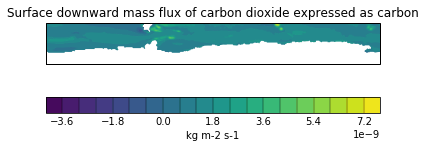

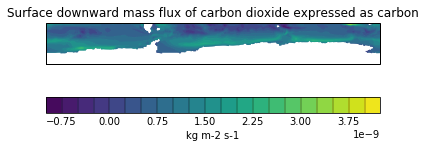

In [243]:
models = ['GFDL-CM4','HadGEM2-ES']
# 'CESM1-BGC' has a very high present-day revelle favtor across much of the region
#'CNRM-CM5' includes zeros over land in its average...
for model in models:
    qplt.contourf(data_dict['seaice_not_masked'][model]['fgco2_map_start'],20)
    qplt.show()